In [2]:
import pandas as pd
import os
from datetime import datetime

from utils import *

# 경로 설정
OPT_PATH  = './SPY_option_data'
VOL_PATH  = './SPY_option_vol_data'
GEX_PATH  = './SPY_GEX_df.csv'
SPOT_PATH = './SPY_SPOT_df.csv'

In [3]:
# 0. GEX 기준 분석 기간 판정 (GEX 데이터의 시간범위가 제일 짧기 때문에 GEX 기준으로 분석 시작일/종료일 판정)
gex_df = pd.read_csv(GEX_PATH, index_col=0, parse_dates=True)
START_DATE, END_DATE = gex_df.index.min(), gex_df.index.max()

In [4]:
# 1. Spot 가격 불러오기 & 필터
spot_df = pd.read_csv(SPOT_PATH, index_col=0, parse_dates=True)
spot_df = spot_df.loc[START_DATE:END_DATE]

In [5]:
# 2. 옵션/변동성 JSON 로드 함수
opt_df = load_jsons_in_range(OPT_PATH, START_DATE, END_DATE)
vol_df = load_jsons_in_range(VOL_PATH, START_DATE, END_DATE)

print(f"로드 완료! opt_df rows: {len(opt_df)}, vol_df rows: {len(vol_df)}")

로드 완료! opt_df rows: 25926, vol_df rows: 233


In [6]:
# 3. opt_df 날짜 변환 & 필터
if not opt_df.empty and 'date' in opt_df.columns:
    opt_df['date'] = pd.to_datetime(opt_df['date'])
    mask_opt = (opt_df['date'] >= START_DATE) & (opt_df['date'] <= END_DATE)
    opt_df = opt_df.loc[mask_opt].reset_index(drop=True)
else:
    print("opt_df에 date 컬럼이 없거나 데이터가 없습니다.")

In [7]:
# 4. vol_df 날짜 변환 & 필터 (존재할 때만)
if not vol_df.empty and 'date' in vol_df.columns:
    vol_df['date'] = pd.to_datetime(vol_df['date'])
    mask_vol = (vol_df['date'] >= START_DATE) & (vol_df['date'] <= END_DATE)
    vol_df = vol_df.loc[mask_vol].reset_index(drop=True)
else:
    print("vol_df에 date 컬럼이 없거나 데이터가 없습니다.")
    vol_df = pd.DataFrame()  # 빈 DataFrame으로 초기화

# 결과 확인
print("=== Final Shapes ===")
print("gex_df:", gex_df.shape)
print("spot_df:", spot_df.shape)
print("opt_df:",  opt_df.shape)
print("vol_df:",  vol_df.shape)

=== Final Shapes ===
gex_df: (251, 4)
spot_df: (251, 6)
opt_df: (25926, 13)
vol_df: (233, 16)


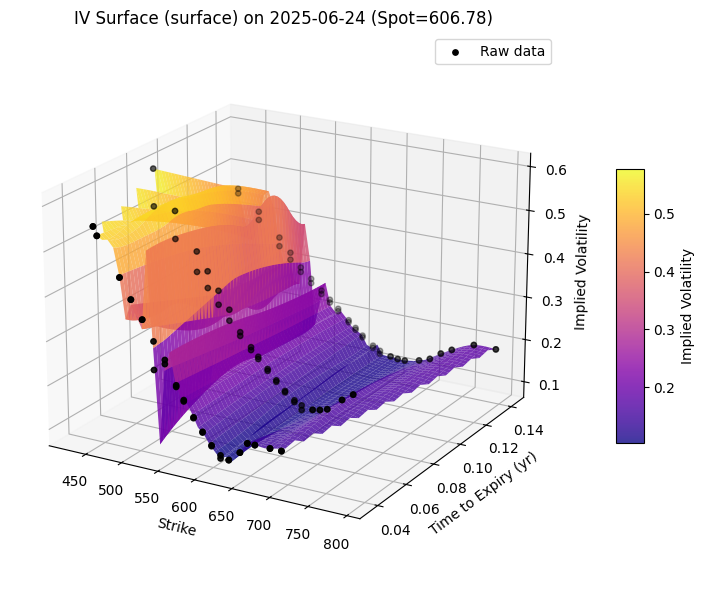

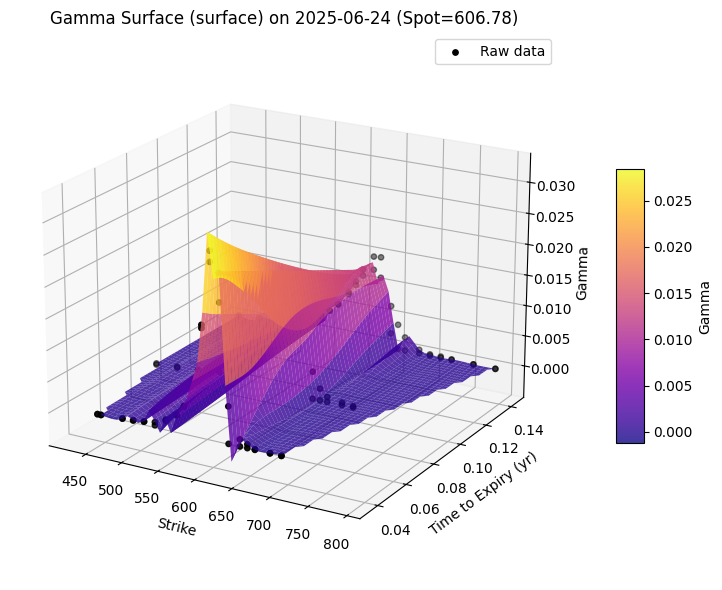

In [22]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def iv_gamma_surface(
    opt_df: pd.DataFrame,
    spot_df: pd.DataFrame,
    snapshot_date,
    grid_T: int = 50,
    grid_K: int = 50,
    style: str = 'surface',
    cmap: str = 'viridis'
) -> pd.DataFrame:
    """
    IV/Gamma 서피스 시각화 (Surface, Wireframe, Contour) 및 원본 데이터 포인트 표시 함수
    
    Parameters:
    -----------
    opt_df : pd.DataFrame
        옵션 체인 데이터 (columns: date, expiration, strike, vol, gamma)
    spot_df : pd.DataFrame
        기초자산 시계열 (index: DateTime, column 'Close')
    snapshot_date : str or pd.Timestamp
        분석 날짜 (e.g. '2025-06-24')
    grid_T, grid_K : int
        보간용 그리드 해상도
    style : {'surface', 'wireframe', 'contour'}
        서피스 스타일
    cmap : str
        matplotlib colormap
    
    Returns:
    --------
    pd.DataFrame
        보간된 그리드 결과 (columns: T, strike, iv, gamma)
    """
    # 1) 날짜 및 데이터 필터링
    date = pd.to_datetime(snapshot_date).normalize()
    df_day = opt_df[opt_df['date'] == date].copy()
    # 만기일, strike, vol, gamma 숫자형 변환
    df_day['expiration'] = pd.to_datetime(df_day['expiration'])
    df_day['strike']     = pd.to_numeric(df_day['strike'], errors='coerce')
    df_day['vol']        = pd.to_numeric(df_day['vol'],    errors='coerce')
    df_day['gamma']      = pd.to_numeric(df_day['gamma'],  errors='coerce')
    df_day.dropna(subset=['strike','vol','gamma'], inplace=True)
    # 남은 시간 T 계산
    df_day['T'] = (df_day['expiration'] - date).dt.days / 365

    # 2) 스팟 가격 가져오기
    spot_price = spot_df.loc[date, 'Close']

    # 3) 보간용 그리드 및 값 준비
    points       = np.vstack((df_day['T'], df_day['strike'])).T
    iv_vals      = df_day['vol'].values
    gamma_vals   = df_day['gamma'].values

    T_lin = np.linspace(df_day['T'].min(), df_day['T'].max(), grid_T)
    K_lin = np.linspace(df_day['strike'].min(), df_day['strike'].max(), grid_K)
    grid_T_mesh, grid_K_mesh = np.meshgrid(T_lin, K_lin)

    iv_surf    = griddata(points, iv_vals,    (grid_T_mesh, grid_K_mesh), method='cubic')
    gamma_surf = griddata(points, gamma_vals, (grid_T_mesh, grid_K_mesh), method='cubic')

    # 4) 플로팅헬퍼
    def plot_3d(data, raw_z, zlabel, title):
        fig = plt.figure(figsize=(12, 6))
        ax  = fig.add_subplot(111, projection='3d')
        if style == 'surface':
            surf = ax.plot_surface(
                grid_K_mesh, grid_T_mesh, data,
                cmap=cmap, edgecolor='none', alpha=0.8
            )
            fig.colorbar(surf, shrink=0.5, aspect=10, label=zlabel)
        elif style == 'wireframe':
            ax.plot_wireframe(
                grid_K_mesh, grid_T_mesh, data,
                rstride=3, cstride=3, linewidth=0.7
            )
        elif style == 'contour':
            ax.contour3D(
                grid_K_mesh, grid_T_mesh, data,
                50, cmap=cmap, linestyles='solid'
            )
        # 원본 포인트 표시
        ax.scatter(
            df_day['strike'], df_day['T'], raw_z,
            c='k', s=15, depthshade=True, label='Raw data'
        )
        ax.legend()
        ax.set_xlabel('Strike')
        ax.set_ylabel('Time to Expiry (yr)')
        ax.set_zlabel(zlabel)
        ax.set_title(f"{title} (Spot={spot_price:.2f})")
        ax.view_init(elev=20, azim=-60)
        plt.tight_layout()
        plt.show()

    # 5) IV 및 Gamma 플롯
    plot_3d(iv_surf,    df_day['vol'],   'Implied Volatility', f'IV Surface ({style}) on {date.date()}')
    plot_3d(gamma_surf, df_day['gamma'], 'Gamma',             f'Gamma Surface ({style}) on {date.date()}')

    # 6) 결과 DataFrame 반환
    result = pd.DataFrame({
        'T':      grid_T_mesh.ravel(),
        'strike': grid_K_mesh.ravel(),
        'iv':     iv_surf.ravel(),
        'gamma':  gamma_surf.ravel()
    })
    return result

# 사용 예시
surf_df = iv_gamma_surface(opt_df, spot_df, '2025-06-24', style='surface', cmap='plasma')